In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os
import time

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
def plot_seg(seg, border=False):
    unique, unique_inverse = np.unique(seg, return_inverse=True)
    N = len(unique)
    cmap = np.random.rand(N,3)
    if border:
        cmap[0,:] = 0
    cmap = matplotlib.colors.ListedColormap(cmap)
    plt.imshow(np.arange(N)[unique_inverse].reshape(seg.shape), cmap=cmap)

# Basil-4K (mip1)

In [5]:
import evaluator

In [6]:
from types import SimpleNamespace

In [7]:
d = dict()

d['gs_input'] = 'gs://neuroglancer/alex/basil/basil_seg_proofread'
d['dtype']   = 'uint32'
d['in_mip']   = 0
d['begin']   = (58199,80712,496) 
d['end']     = None
d['center']  = None
d['size']    = (2048,2048,256)
d['cache']   = True
d['parallel'] = 8

opt = SimpleNamespace(**d)

In [8]:
%%capture
gt = evaluator.cutout(opt, dtype=opt.dtype)

gs://neuroglancer/alex/basil/basil_seg_proofread
begin = (58199, 80712, 496)
end = (60247, 82760, 752)
mip 0 = [slice(58199, 60247, None), slice(80712, 82760, None), slice(496, 752, None)]
mip 0 = [slice(58199, 60247, 1), slice(80712, 82760, 1), slice(496, 752, 1)]


Downloading: 252it [00:10, 17.52it/s]                         
Downloading: 254it [00:10, 13.46it/s]                         
Downloading: 246it [00:11, 15.38it/s]                         
Downloading: 254it [00:11, 14.95it/s]                         
Downloading: 252it [00:11, 17.80it/s]                         
Downloading: 250it [00:11, 18.46it/s]                         
Downloading: 252it [00:11, 18.73it/s]                         
Downloading: 252it [00:11, 19.60it/s]                         


In [9]:
print(gt.shape)

(256, 2048, 2048)


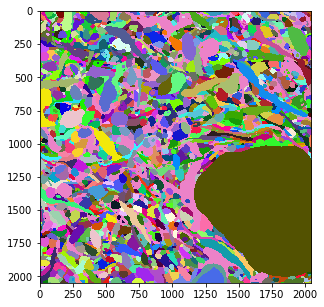

In [10]:
z = 128
plt.figure(figsize=(5,5))
plot_seg(gt[z,:,:], border=True)
plt.show()

## Valid segment list

In [11]:
home = os.path.expanduser('~')
base = os.path.join(home, 'seungmount/research/Alex/errordetection/basil')
print(base)

/usr/people/kisuk/seungmount/research/Alex/errordetection/basil


In [12]:
fname = 'chunk_116398-120494_161424-165520_496-752.omni.segments.txt'
fpath = os.path.join(base, fname)

In [13]:
# Read data
x = np.loadtxt(fpath, dtype='uint32', delimiter=',', skiprows=2)

In [14]:
invalid_idx = (x[:,1] != 2)
invalid_ids = x[invalid_idx,0]

In [16]:
idx = np.isin(gt, invalid_ids)

In [18]:
gt_valid = np.copy(gt)

In [19]:
gt_valid[idx] = 0

In [26]:
# Nucleus
gt_valid[gt_valid==4245] = 0

## Basil segmentation

In [32]:
d = dict()

d['gs_input'] = 'gs://neuroglancer/basil_v0/basil_full/seg-aug'
d['dtype']   = 'uint64'
d['in_mip']   = 0
d['begin']   = (58199,80712,496) 
d['end']     = None
d['center']  = None
d['size']    = (2048,2048,256)
d['cache']   = True
d['parallel'] = 8

opt = SimpleNamespace(**d)

In [33]:
%%capture
seg = evaluator.cutout(opt, dtype=opt.dtype)

In [36]:
# Nucleus
gt_valid[seg==5092179087309] = 0

In [43]:
# Nucleus
gt_valid[seg==5082636691444] = 0

In [46]:
# Axon merger
gt_valid[gt==91973] = 0

## Ingest

In [47]:
d = dict()
gs_path = 'gs://neuroglancer/alex/basil/basil_seg_proofread_valid_v2'
d['gs_output'] = gs_path
d['vol_type'] = 'segmentation'
d['offset'] = (58199,80712,496)
d['resolution'] = (8,8,40)
d['parallel'] = 8
d['downsample'] = True
d['chunk_size'] = (64,64,16)

opt = SimpleNamespace(**d)

In [48]:
%%capture
evaluator.ingest(gt_valid.astype(np.uint32), opt)

## Save

In [53]:
import h5py

In [54]:
with h5py.File("seg_valid.h5", 'w') as f:
    f.create_dataset('/main', data=gt_valid.astype(np.uint32))